In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def fix(s):
    firstcolon = s.find(":")
    s_new = s[firstcolon-2:firstcolon] + s[firstcolon+1:firstcolon+3]
    s_new = s_new.replace("*", "0")
    return s_new

def compute_resolution(gs_val,pre_val):
    gs_all = gs_val.split("/")
    pre_fixed = fix(pre_val)
    flag = False #false = inaccurate, turn to true = 2 digits accurate
    
    for val in gs_all:
        gs_fixed = fix(val)

        if (gs_fixed[0:2] == pre_fixed[0:2]):
            if (gs_fixed[2:4] == pre_fixed[2:4]):
                return 4
            flag = True
        
    return 2 if flag==True else 0

In [7]:
# requirements: gs accession numbers are under a column labeled "Run" 
#pre accession numbers are under a column labeled "ERR" 
# accession numbers/column titles are labeled identically between gold standard and results csv
# Only accuracy for samples in both GS and PRE are calculated. Samples in PRE, but not in GS are ignored. Samples in GS, but not in PRE, are tallied in the "failed" variable 
def compute_matches(pre,gs):

    # index 0 is class I, index 1 is class II
    fourdig = [0,0]
    twodig = [0,0]
    zerodig = [0,0]
    fail = 0

    d5 = ['Run', 'A', 'B']
    d6 = ['Run', 'C']
    classI = ['A','B','C']

    accession_numbers = gs["Run"].values.tolist()
    genes = gs.columns.values.tolist()

    for number in accession_numbers:
        pre_row = pre.loc[pre['ERR'] == number]
        gs_row = gs.loc[gs['Run'] == number]

        # if we are working with d5 or d6, the monoallelic datasets
        if (gs.columns.tolist() == d5 or gs.columns.tolist() == d6):
            for i in range(1,len(genes)):
                gs_val = gs_row[genes[i]].astype(str).values[0]
                pre_val1 = pre_row[genes[i]].astype(str).values[0]
                pre_val2 = pre_row[genes[i]+".1"].astype(str).values[0]

                ans = max(compute_resolution(gs_val,pre_val1), compute_resolution(gs_val,pre_val2))
                if (ans == 0):
                    zerodig[0] = zerodig[0] + 1
                if (ans == 2):
                    twodig[0] = twodig[0] + 1
                if (ans == 4):
                    fourdig[0] = fourdig[0] + 1

        # if we are working with d1-d4, the biallelic datasets
        else:
            for i in range(1,len(genes),2):
                try:
                    gs_val1 = gs_row[genes[i]].astype(str).values[0]
                    pre_val1 = pre_row[genes[i]].astype(str).values[0]
                    gs_val2 = gs_row[genes[i+1]].astype(str).values[0]
                    pre_val2 = pre_row[genes[i+1]].astype(str).values[0]

                    if gs_val1 == None or pre_val1 == None or gs_val2 == None or pre_val2 == None:
                        fail = fail+1
                        continue

                    # assuming no swapping 
                    ans1 = compute_resolution(gs_val1,pre_val1)
                    ans2 = compute_resolution(gs_val2,pre_val2)

                    # assuming swapping
                    ans3 = compute_resolution(gs_val1,pre_val2)
                    ans4 = compute_resolution(gs_val2,pre_val1)

                    if (ans1+ans2 > ans3+ans4):
                        if (ans1 == 0):
                            if classI.contains(pre_val1[0]):
                                zerodig[0] += 1 
                            else:
                                zerodig[1] += 1
                        if (ans1 == 2):
                            if classI.contains(pre_val1[0]):
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans1 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                        if (ans2 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans2 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans2 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                    else:
                        if (ans3 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans3 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans3 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                        if (ans4 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans4 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans4 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                except:
                    fail = fail+1

    return zerodig,twodig,fourdig #,fail #onzero fail indicates exception occurred

In [8]:
data = list()
tools=["optitype","arcas","rna2hla","hlaforest","seq2hla","hlahd","phlat","hlavbseq"]
#datasets=["1","d2","d3","d4","d5","d6"]
for t in tools:
    total = []
    for d in range(1,7):
        gs=pd.read_csv("../datasets/"+str(d)+"_gs.csv")
        pre=pd.read_csv("../results/standard/"+str(t)+"_d"+str(d)+".csv")
        ret=compute_matches(pre,gs)
        print(t,"d"+str(d),ret)
        total.append(ret)
    data.append(total)

optitype d1 ([6, 0], [8, 0], [280, 0])
optitype d2 ([13, 0], [25, 0], [2892, 0])
optitype d3 ([0, 0], [0, 0], [0, 0])
optitype d4 ([0, 0], [0, 0], [0, 0])
optitype d5 ([4, 0], [0, 0], [4, 0])
optitype d6 ([0, 0], [0, 0], [8, 0])
arcas d1 ([8, 0], [59, 0], [189, 0])
arcas d2 ([38, 6], [95, 99], [2711, 1801])
arcas d3 ([0, 4], [0, 5], [0, 163])
arcas d4 ([0, 24], [0, 0], [0, 4])
arcas d5 ([3, 0], [0, 0], [5, 0])
arcas d6 ([0, 0], [0, 0], [8, 0])
rna2hla d1 ([12, 0], [21, 0], [257, 0])
rna2hla d2 ([37, 45], [78, 33], [2779, 898])
rna2hla d3 ([0, 14], [0, 23], [0, 127])
rna2hla d4 ([0, 20], [0, 1], [0, 5])
rna2hla d5 ([4, 0], [1, 0], [3, 0])
rna2hla d6 ([0, 0], [2, 0], [6, 0])
hlaforest d1 ([20, 0], [31, 0], [233, 0])
hlaforest d2 ([89, 36], [335, 201], [2264, 1663])
hlaforest d3 ([0, 5], [0, 26], [0, 141])
hlaforest d4 ([0, 10], [0, 4], [0, 10])
hlaforest d5 ([4, 0], [2, 0], [2, 0])
hlaforest d6 ([0, 0], [0, 0], [8, 0])
seq2hla d1 ([12, 0], [21, 0], [257, 0])
seq2hla d2 ([37, 111], [78, 1

In [9]:
# sorting through code to create dataframes for Class I and Class II results
df = pd.DataFrame(data)
data = np.array(data)

classIresults = []
classIIresults = []

for tool in data:
    r = sum(tool)
    classIresults.append(r[:,0])
    classIIresults.append(r[:,1])

# normalizing accuracies to 1
classIresults = np.array(classIresults)
row_sums = classIresults.sum(axis=1)
classIresults = classIresults / row_sums[:, np.newaxis]


classIIresults = np.array(classIIresults)
row_sums = classIIresults.sum(axis=1)
classIIresults = classIIresults / row_sums[:, np.newaxis]
np.nan_to_num(classIIresults,0)


print(classIresults)
print(classIIresults)




[[0.00709877 0.01018519 0.98271605]
 [0.01572529 0.04942234 0.93485237]
 [0.0165625  0.031875   0.9515625 ]
 [0.03781794 0.1231593  0.83902276]
 [0.0165625  0.031875   0.9515625 ]
 [0.05971087 0.04556882 0.8947203 ]
 [0.02815979 0.06024885 0.91159136]
 [0.10084034 0.05042017 0.8487395 ]]
[[0.         0.         0.        ]
 [0.01614435 0.04938272 0.93447293]
 [0.067753   0.04888508 0.88336192]
 [0.02433206 0.11020992 0.86545802]
 [0.0858349  0.09427767 0.81988743]
 [0.06238274 0.03001876 0.9075985 ]
 [0.10927573 0.06416773 0.82655654]
 [0.92634561 0.01369216 0.05996223]]


/var/folders/j4/pd1pbcl90xz683wfkd2drjqw0000gn/T/ipykernel_43054/2841973356.py:21: RuntimeWarning: invalid value encountered in true_divide
  classIIresults = classIIresults / row_sums[:, np.newaxis]


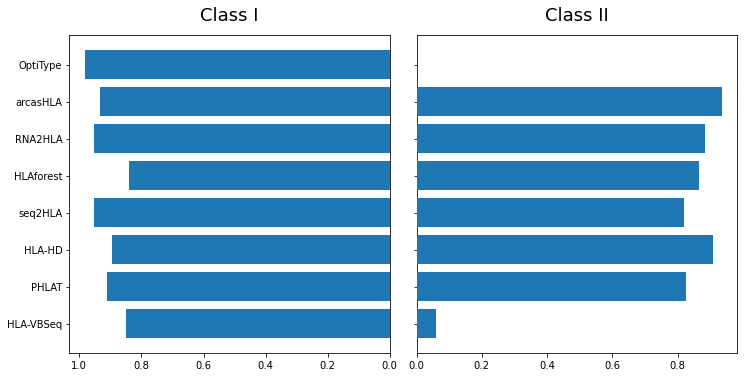

In [10]:
# plotting 0 4dig accuracy

index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq"]
title0 = 'Class I'
title1 = 'Class II'

fourdig_I = classIresults[:,2]
fourdig_II = classIIresults[:,2]

fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, fourdig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, fourdig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

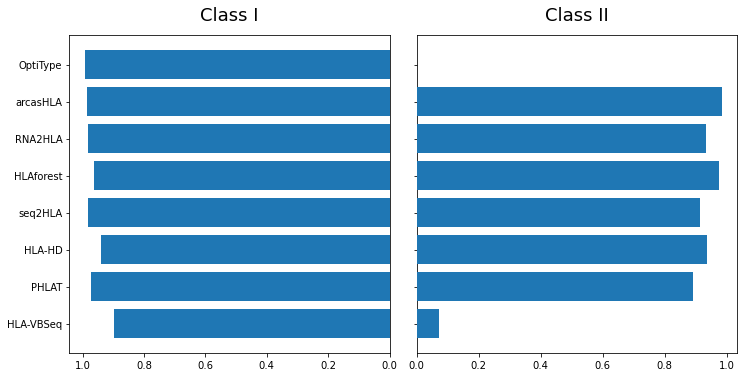

In [17]:
# plotting 2 dig accuracy


index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq"]
title0 = 'Class I'
title1 = 'Class II'
twodig_I = classIresults[:,1]+classIresults[:,2]
twodig_II = classIIresults[:,1]+classIIresults[:,2]


fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, twodig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, twodig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

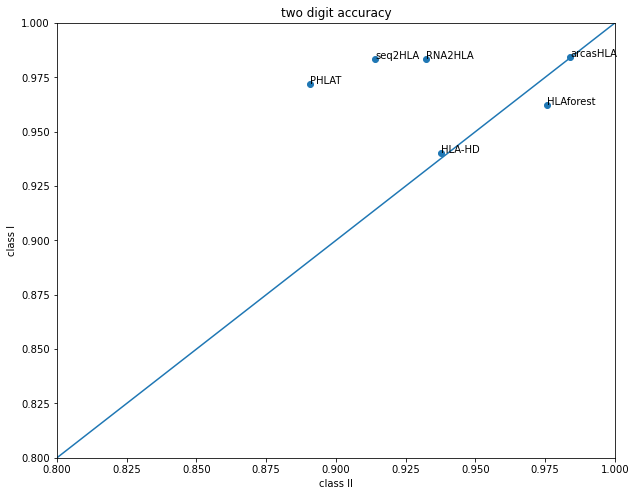

In [57]:
tools = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq"]

plt.figure(figsize = (10,8))

plt.scatter(twodig_II,twodig_I)

for i, txt in enumerate(tools):
    plt.annotate(txt, (twodig_II[i], twodig_I[i]))


plt.xlabel("class II")
plt.ylabel("class I")
plt.xlim([0.8,1])
plt.ylim([0.8,1])
plt.title('two digit accuracy')


plt.plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))

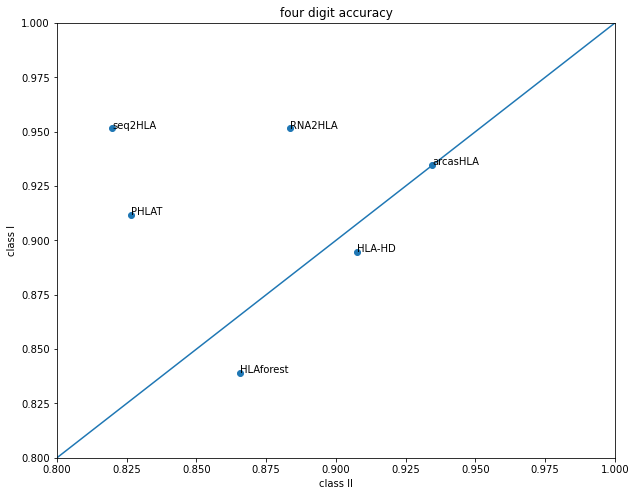

In [56]:

plt.figure(figsize = (10,8))

plt.scatter(fourdig_II,fourdig_I)

for i, txt in enumerate(tools):
    plt.annotate(txt, (fourdig_II[i], fourdig_I[i]))
    
plt.xlabel("class II")
plt.ylabel("class I")
plt.xlim([0.8,1])
plt.ylim([0.8,1])
plt.title('four digit accuracy')

plt.plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))